In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
df_raw = pd.read_csv("annthyroid.csv", header=None)
df_raw.loc[df_raw[21] == -1, 21] = 0
device = "cpu"
y = pd.get_dummies(df_raw.iloc[:,-1])
y = torch.Tensor(y.values).to(device)
x = df_raw.iloc[:,:-1]
x = torch.Tensor(x.values).to(device)
num_split = int(len(x) * 0.8)
print(num_split)
x_train = x[:num_split,:]
x_test = x[num_split:,:]
y_train = y[:num_split,:]
y_test = y[num_split:,:]

5672


In [3]:
df_raw[21].value_counts()

1    6563
0     527
Name: 21, dtype: int64

In [4]:
x_train_p_list = []
y_train_p_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([0.,1.])):
        #print("c")
        x_train_p_list.append(x_train[i])
        y_train_p_list.append(y_train[i])
#print(x_train_M_list)
y_train_p = torch.stack(y_train_p_list)
x_train_p = torch.stack(x_train_p_list)
x_train_n_list = []
y_train_n_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([1.,0.])):
        #print("c")
        x_train_n_list.append(x_train[i])
        y_train_n_list.append(y_train[i])
#print(x_train_M_list)
y_train_n = torch.stack(y_train_n_list)
x_train_n = torch.stack(x_train_n_list)
print(len(x_train_p))
print(len(x_train_n))

5243
429


In [5]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=21):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var
    
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]
    
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [6]:
num_features = 8
model = VariationalAutoencoder(num_features=num_features)
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 1000

In [7]:
custom_dataset_x_train_n = AutoencoderDataset(x_train_n)

train_loader = DataLoader(
    custom_dataset_x_train_n,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [8]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "variational-autoencoder_annthyroid_n.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s, loss=204]


Ave Loss: 203.70970153808594
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.16it/s, loss=107]


Ave Loss: 106.97599792480469
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s, loss=50.1]


Ave Loss: 50.08641052246094
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.03it/s, loss=24.7]


Ave Loss: 24.689682006835938
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.60it/s, loss=16.2]


Ave Loss: 16.188199996948242
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s, loss=16]


Ave Loss: 16.02096176147461
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s, loss=20.5]


Ave Loss: 20.50792694091797
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s, loss=26.3]


Ave Loss: 26.34389877319336
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s, loss=30.2]


Ave Loss: 30.24468994140625
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s, loss=30.8]


Ave Loss: 30.792882919311523
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s, loss=28.7]


Ave Loss: 28.656965255737305
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=25.1]


Ave Loss: 25.09865951538086
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=20.9]


Ave Loss: 20.91192626953125
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=16.4]


Ave Loss: 16.396066665649414
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s, loss=12]


Ave Loss: 11.98932933807373
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=8.27]


Ave Loss: 8.273323059082031
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=5.74]


Ave Loss: 5.743760108947754
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.49it/s, loss=4.45]


Ave Loss: 4.449102878570557
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=4.16]


Ave Loss: 4.158616542816162
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=4.58]


Ave Loss: 4.576385498046875
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=5.49]


Ave Loss: 5.491837978363037
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=6.67]


Ave Loss: 6.672945022583008
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s, loss=7.73]


Ave Loss: 7.727704048156738
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s, loss=8.2]


Ave Loss: 8.19653034210205
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.61it/s, loss=7.82]


Ave Loss: 7.817437648773193
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=6.7]


Ave Loss: 6.696923732757568
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=5.22]


Ave Loss: 5.224701881408691
Epoch: 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s, loss=3.82]


Ave Loss: 3.822409152984619
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=2.74]


Ave Loss: 2.741724967956543
Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s, loss=2.05]


Ave Loss: 2.0487489700317383
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=1.71]


Ave Loss: 1.7128360271453857
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=1.7]


Ave Loss: 1.6959773302078247
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=1.92]


Ave Loss: 1.9221231937408447
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=2.24]


Ave Loss: 2.2430734634399414
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s, loss=2.49]


Ave Loss: 2.4907054901123047
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s, loss=2.57]


Ave Loss: 2.570932149887085
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=2.51]


Ave Loss: 2.5050151348114014
Epoch: 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=2.34]


Ave Loss: 2.3419783115386963
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=2.11]


Ave Loss: 2.1137216091156006
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s, loss=1.83]


Ave Loss: 1.8315227031707764
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.16it/s, loss=1.53]


Ave Loss: 1.5320687294006348
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s, loss=1.28]


Ave Loss: 1.280835747718811
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=1.11]


Ave Loss: 1.1149063110351562
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s, loss=1.04]


Ave Loss: 1.0367441177368164
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=1.01]


Ave Loss: 1.0131038427352905
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=1.04]


Ave Loss: 1.0372061729431152
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=1.09]


Ave Loss: 1.0924313068389893
Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.04it/s, loss=1.15]


Ave Loss: 1.15183687210083
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=1.17]


Ave Loss: 1.171199083328247
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=1.14]


Ave Loss: 1.1350533962249756
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s, loss=1.05]


Ave Loss: 1.0498086214065552
Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s, loss=0.944]


Ave Loss: 0.9436407685279846
Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s, loss=0.849]


Ave Loss: 0.8494939804077148
Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s, loss=0.769]


Ave Loss: 0.7689299583435059
Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.715]


Ave Loss: 0.7146409749984741
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.687]


Ave Loss: 0.6868205666542053
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.687]


Ave Loss: 0.6868090629577637
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.47it/s, loss=0.706]


Ave Loss: 0.7061567902565002
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s, loss=0.722]


Ave Loss: 0.7221776247024536
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s, loss=0.722]


Ave Loss: 0.721657395362854
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.49it/s, loss=0.702]


Ave Loss: 0.7019271850585938
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.671]


Ave Loss: 0.670997142791748
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.638]


Ave Loss: 0.637859582901001
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s, loss=0.604]


Ave Loss: 0.6037976145744324
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.581]


Ave Loss: 0.5809571743011475
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s, loss=0.561]


Ave Loss: 0.5605361461639404
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s, loss=0.55]


Ave Loss: 0.5497217774391174
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.65it/s, loss=0.539]


Ave Loss: 0.5394862294197083
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.533]


Ave Loss: 0.5328305959701538
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.524]


Ave Loss: 0.5241849422454834
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.52]


Ave Loss: 0.5204739570617676
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.515]


Ave Loss: 0.5152910351753235
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.47it/s, loss=0.503]


Ave Loss: 0.5034358501434326
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.486]


Ave Loss: 0.48594677448272705
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.59it/s, loss=0.471]


Ave Loss: 0.4705843925476074
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.459]


Ave Loss: 0.4592023193836212
Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s, loss=0.448]


Ave Loss: 0.44829487800598145
Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.438]


Ave Loss: 0.43829700350761414
Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.62it/s, loss=0.431]


Ave Loss: 0.4308885335922241
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.427]


Ave Loss: 0.4270741045475006
Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s, loss=0.421]


Ave Loss: 0.42081087827682495
Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.418]


Ave Loss: 0.41834306716918945
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.407]


Ave Loss: 0.40720170736312866
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.401]


Ave Loss: 0.40127894282341003
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.394]


Ave Loss: 0.3944157063961029
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.387]


Ave Loss: 0.3865624666213989
Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.47it/s, loss=0.378]


Ave Loss: 0.37847501039505005
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.375]


Ave Loss: 0.3748839497566223
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s, loss=0.371]


Ave Loss: 0.3712174594402313
Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s, loss=0.367]


Ave Loss: 0.36659207940101624
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.45it/s, loss=0.362]


Ave Loss: 0.3624846935272217
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.48it/s, loss=0.36]


Ave Loss: 0.35985976457595825
Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s, loss=0.355]


Ave Loss: 0.35482120513916016
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s, loss=0.348]


Ave Loss: 0.3482232093811035
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.01it/s, loss=0.344]


Ave Loss: 0.3439621329307556
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s, loss=0.341]


Ave Loss: 0.3407254219055176
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 39.91it/s, loss=0.337]


Ave Loss: 0.3370792269706726
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s, loss=0.333]


Ave Loss: 0.33344247937202454
Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s, loss=0.332]


Ave Loss: 0.33221128582954407
Epoch: 99


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.46it/s, loss=0.33]


Ave Loss: 0.3295770287513733


In [9]:
sampled_mu = torch.Tensor([np.zeros(num_features)])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

C:\Users\JMARANAN\AppData\Local\Temp\ipykernel_17144\2407897311.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


In [10]:
x_train_n_list = []
y_train_n_list = []
for i in range(len(y_train)):
    #print(y_train[i])
    if y_train[i].equal(torch.tensor([0.,1.])):
        #print("c")
        x_train_n_list.append(x_train[i])
        y_train_n_list.append(y_train[i])
#print(x_train_M_list)
y_train_n = torch.stack(y_train_n_list)
x_train_n = torch.stack(x_train_n_list)
for i in range(len(x_train_p)-len(x_train_n)):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    # print(reconstruction)
    x_train_n_list.append(reconstruction[0])
    y_train_n_list.append(y_train_n_list[0])
x_train_n = torch.stack(x_train_n_list)
y_train_n = torch.stack(y_train_n_list)
print(len(x_train_p))
print(len(x_train_n))
print(len(y_train_p))
print(len(y_train_n))
x_train_ext = torch.cat((x_train_p, x_train_n), 0)
y_train_ext = torch.cat((y_train_p, y_train_n), 0)
print(len(x_train_ext))
print(len(y_train_ext))

5243
5243
5243
5243
10486
10486


In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 500) # input to first hidden layer
        self.hidden_layer_2 = nn.Linear(500, 10)
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 10),
            nn.ReLU(inplace=True),
        )
        
        self.output_layer = nn.Linear(10, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        
        x = self.hidden_layer_2(x)
        
        x = self.multiple_layers(x)
        
        y = self.output_layer(x)
        
        #y = self.activation(y)
        
        return y
    
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
def one_hot_encoding(nd_array):
        one_hot_encoding_predictions = nd_array.clone().detach()

        for i in range(len(nd_array)):
            max_pred = max(nd_array[i])

            for j in range(len(nd_array[i])):
                one_hot_encoding_predictions[i][j] = 1 if nd_array[i][j] == max_pred else 0

        return one_hot_encoding_predictions
    
def accuracy_test(y_test, y_pred):
    y_test = y_test.clone().detach()
    y_pred = y_pred.clone().detach()
    true_p = 0
    for i in range(len(y_test)):
        if y_test[i].equal(y_pred[i]):
            print(y_pred[i])
            true_p += 1
    return true_p / len(y_test)

def train_fn_eval(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.58it/s, loss=0.612]


Ave Loss: 0.6292824853550304
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.56]


Ave Loss: 0.5862929333340038
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s, loss=0.467]


Ave Loss: 0.511909159747037
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.36it/s, loss=0.337]


Ave Loss: 0.4028897854414853
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.07it/s, loss=0.0358]


Ave Loss: 0.1844412118873813
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.41it/s, loss=0.0162]


Ave Loss: 0.02590602003461258
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.37it/s, loss=0.0118]


Ave Loss: 0.0075579173439605666
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.25it/s, loss=0.00228]


Ave Loss: 0.004029665068215268
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.76it/s, loss=0.0012]


Ave Loss: 0.0022133954546668315
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.29it/s, loss=0.00115]


Ave Loss: 0.0012852258408780801
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.64it/s, loss=0.00101]


Ave Loss: 0.0009945960006337953
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.96it/s, loss=0.000996]


Ave Loss: 0.000924039499791847
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.76it/s, loss=0.000915]


Ave Loss: 0.0008782630003142086
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.03it/s, loss=0.000906]


Ave Loss: 0.000858366859822788
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.15it/s, loss=0.000876]


Ave Loss: 0.000833853862290694
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.07it/s, loss=0.000859]


Ave Loss: 0.0008161682794293897
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.50it/s, loss=0.000838]


Ave Loss: 0.0007973832543939352
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.71it/s, loss=0.00082]


Ave Loss: 0.0007802569995295595
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.03it/s, loss=0.000802]


Ave Loss: 0.0007634047757495533
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.48it/s, loss=0.000784]


Ave Loss: 0.0007472605052912099
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.00it/s, loss=0.000767]


Ave Loss: 0.0007316808332689106
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.41it/s, loss=0.00075]


Ave Loss: 0.0007166941015219146
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.95it/s, loss=0.000735]


Ave Loss: 0.000702291166155853
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.23it/s, loss=0.000719]


Ave Loss: 0.0006884664551100948
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.25it/s, loss=0.000705]


Ave Loss: 0.000675199093000794
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.37it/s, loss=0.000691]


Ave Loss: 0.0006624860265715556
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.82it/s, loss=0.000677]


Ave Loss: 0.0006502960618077354
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.54it/s, loss=0.000664]


Ave Loss: 0.000638621525881304
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.30it/s, loss=0.000652]


Ave Loss: 0.0006274312724020671
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.00064]


Ave Loss: 0.0006167108817449348
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.42it/s, loss=0.000629]


Ave Loss: 0.0006064335095950148
Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.26it/s, loss=0.000617]


Ave Loss: 0.0005965783281929114
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.18it/s, loss=0.000607]


Ave Loss: 0.0005871227688410065
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.99it/s, loss=0.000597]


Ave Loss: 0.0005780441040935165
Epoch: 34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.000587]


Ave Loss: 0.0005693211728198962
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.33it/s, loss=0.000577]


Ave Loss: 0.0005609327662651511
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.12it/s, loss=0.000568]


Ave Loss: 0.000552860384976322
Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.73it/s, loss=0.000559]


Ave Loss: 0.0005450826191174036
Epoch: 38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.37it/s, loss=0.000551]


Ave Loss: 0.0005375829112546688
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.53it/s, loss=0.000543]


Ave Loss: 0.00053034403456629
Epoch: 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.22it/s, loss=0.000535]


Ave Loss: 0.0005233493469528515
Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s, loss=0.000527]


Ave Loss: 0.0005165848150764676
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.30it/s, loss=0.00052]


Ave Loss: 0.0005100365325977856
Epoch: 43


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.74it/s, loss=0.000512]


Ave Loss: 0.0005036905878858471
Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.74it/s, loss=0.000505]


Ave Loss: 0.0004975363739173521
Epoch: 45


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.26it/s, loss=0.000499]


Ave Loss: 0.0004915621168699793
Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.29it/s, loss=0.000492]


Ave Loss: 0.00048575823100029743
Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.11it/s, loss=0.000486]


Ave Loss: 0.00048011536604132164
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.19it/s, loss=0.00048]


Ave Loss: 0.0004746246876576069
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.42it/s, loss=0.000474]


Ave Loss: 0.00046927885903807527
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.48it/s, loss=0.000468]


Ave Loss: 0.00046407026027075267
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.72it/s, loss=0.000462]


Ave Loss: 0.00045899272663518786
Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.66it/s, loss=0.000456]


Ave Loss: 0.0004540398552886803
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.51it/s, loss=0.000451]


Ave Loss: 0.0004492066430181942
Epoch: 54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.04it/s, loss=0.000446]


Ave Loss: 0.0004444876765112647
Epoch: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.08it/s, loss=0.000441]


Ave Loss: 0.000439877240833911
Epoch: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.93it/s, loss=0.000436]


Ave Loss: 0.00043537235152061015
Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.80it/s, loss=0.000431]


Ave Loss: 0.00043096798154610127
Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.26it/s, loss=0.000426]


Ave Loss: 0.00042665973358618265
Epoch: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.24it/s, loss=0.000421]


Ave Loss: 0.0004224458455362103
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.70it/s, loss=0.000417]


Ave Loss: 0.00041832146763970906
Epoch: 61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.42it/s, loss=0.000413]


Ave Loss: 0.00041428345668298954
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.81it/s, loss=0.000408]


Ave Loss: 0.0004103291218846359
Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.03it/s, loss=0.000404]


Ave Loss: 0.0004064554576127028
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.80it/s, loss=0.0004]


Ave Loss: 0.00040265960110859436
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.38it/s, loss=0.000396]


Ave Loss: 0.0003989383694715798
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.99it/s, loss=0.000392]


Ave Loss: 0.00039529091339897025
Epoch: 67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.66it/s, loss=0.000388]


Ave Loss: 0.00039171251013282347
Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.20it/s, loss=0.000385]


Ave Loss: 0.00038820254849269986
Epoch: 69


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.56it/s, loss=0.000381]


Ave Loss: 0.00038475835621780294
Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.67it/s, loss=0.000377]


Ave Loss: 0.0003813776076474989
Epoch: 71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.09it/s, loss=0.000374]


Ave Loss: 0.0003780578342478045
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.04it/s, loss=0.00037]


Ave Loss: 0.000374797133686529
Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.000367]


Ave Loss: 0.00037159379677508366
Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.41it/s, loss=0.000364]


Ave Loss: 0.00036844558781012893
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.92it/s, loss=0.000361]


Ave Loss: 0.00036535112832842225
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.70it/s, loss=0.000357]


Ave Loss: 0.0003623084128114649
Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.85it/s, loss=0.000354]


Ave Loss: 0.000359315001829104
Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.23it/s, loss=0.000351]


Ave Loss: 0.00035636971270750195
Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.88it/s, loss=0.000348]


Ave Loss: 0.0003534707357175648
Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.70it/s, loss=0.000345]


Ave Loss: 0.0003506160018415275
Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.000343]


Ave Loss: 0.0003478044845079157
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.00034]


Ave Loss: 0.00034503386334770107
Epoch: 83


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.00it/s, loss=0.000337]


Ave Loss: 0.00034230284720913255
Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.79it/s, loss=0.000334]


Ave Loss: 0.0003396099517968568
Epoch: 85


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.71it/s, loss=0.000332]


Ave Loss: 0.0003369537060445344
Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.86it/s, loss=0.000329]


Ave Loss: 0.0003343318901236423
Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.54it/s, loss=0.000326]


Ave Loss: 0.00033174335840158165
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.92it/s, loss=0.000324]


Ave Loss: 0.00032918686999685383
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.04it/s, loss=0.000321]


Ave Loss: 0.0003266606204719706
Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.38it/s, loss=0.000319]


Ave Loss: 0.00032416341127827764
Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.92it/s, loss=0.000316]


Ave Loss: 0.0003216932871675288
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.83it/s, loss=0.000314]


Ave Loss: 0.00031924928242171353
Epoch: 93


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.42it/s, loss=0.000311]


Ave Loss: 0.00031682984660040927
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.62it/s, loss=0.000309]


Ave Loss: 0.000314433355180716
Epoch: 95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22.87it/s, loss=0.000306]


Ave Loss: 0.00031205848526124925
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s, loss=0.000304]


Ave Loss: 0.00030970409120941025
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.32it/s, loss=0.000302]


Ave Loss: 0.0003073684611908075
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.68it/s, loss=0.000299]


Ave Loss: 0.00030505066917447203
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.30it/s, loss=0.000297]


Ave Loss: 0.0003027489795137874


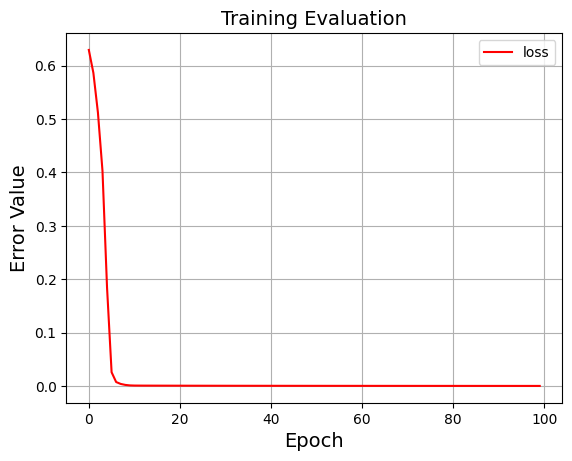

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.])
tensor([0., 1.

0.9308885754583921

In [12]:
model_ext = NeuralNetwork(21, 2)

learning_rate = 0.001
loss_fn = nn.MSELoss()
batch_size = 1000
optimizer = optim.Adam(model_ext.parameters(), lr=learning_rate)
x_train_ext = x_train_ext.clone().detach()
y_train_ext = y_train_ext.clone().detach()
custom_dataset_ext = MyCustomDataset(x=x_train_ext, y=y_train_ext)

train_loader_ext = DataLoader(
    custom_dataset_ext,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

losses = []
epochs = 100

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_eval(
        train_loader_ext,
        model_ext,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model_ext.state_dict() }

    torch.save(state, "model_annthyroid_ext.pth")
    
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

y_pred = one_hot_encoding(model_ext.forward(x_test))
accuracy_test(y_test, y_pred)

In [13]:
y_pred

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])